# SMAI Assignment - 2

## Question - `2` : Face Recognition using Principal Component Analysis

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `16.02.2023` |
| Due Date | `24.02.2023` |

### <b>Objective:</b>
This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

### <b>About the dataset:</b>  
The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)



### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.


#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []       # array of cv2 images
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[:int(trainAmt*len(allFaces))]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Treating each pixel as a feature results in a (w\*h)x(w\*h) covariance matrix. Finding the eigenvalues/vectors for this matrix is not even feasible (I even tried with cuda).
But since we just have 400 images which is << than the number of features, there will only be 400 meaningful eignenvectors


If $A^TA \bold{v}_{\textit{i}} = \mu_{\textit{i}}\bold{v}_{\textit{i}}$, 
<br>pre-multiply A to get<br>
$AA^TA \bold{v}_{\textit{i}} = \mu_{\textit{i}}A\bold{v}_{\textit{i}}$, 

Thus, $A\bold{v}_{\textit{i}}$ is an eigenvalue for $AA^T$ for all $\textit{i}$

Instead of decomposing $AA^T$, we decompose $A^TA$ instead. $A\bold{v}_{\textit{i}}$ describes a linear combination of faces that can produce any face in face-space

In [146]:
"""
Implement pca in the following function by taking the following arguements:
1. X(images array)
2. number of components
The function must return the eigen vectors (principal components) also termed "Eigen faces"
"""

%matplotlib inline

def principalComponentAnalysis(x, numComponents=50):
    numImages = x.shape[0]

    # normalise data, (subtract avg face)
    imgVectors = (x.reshape(numImages, -1)).astype(np.float64)
    psi = np.mean(imgVectors, axis=0).astype(np.float64)     # aka meanFace

    # sigma = np.sum(np.square((imgVectors - mu).astype(np.float64)), axis=0)/imgVectors.shape[0]
    # sigma = np.sqrt(sigma)

    nImgVectors = imgVectors - psi       # aka Phi

    # generate a covariance matrix and eigen values
    print("Generating covariance matrix...")
    L = nImgVectors@nImgVectors.T   # AT A in the paper

    print("Generating eigenfaces...")
    eigenvalues, eigenvectors = np.linalg.eigh(L)   # 360 eigenvalues/vectors
    order = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors.T[order]


    # # print((cov)@eigenvectors[:,-1] - eigenvalues[-1]*eigenvectors[:,-1])

    eigenfaces = (eigenvectors@nImgVectors)

    return eigenfaces[:numComponents], psi

(360, 10304)
Generating covariance matrix...
(360, 360)
Generating eigenfaces...
[[-5.47655214e-02 -6.11789026e-02  7.84352099e-02 ...  8.73306964e-02
   6.84336349e-02 -9.80464065e-04]
 [ 3.07672031e-02 -1.09373162e-04 -1.17323780e-02 ...  4.05317475e-02
  -2.25579511e-02 -1.10220631e-02]
 [-5.60367049e-02  2.23324369e-02 -9.44821387e-02 ... -1.89571179e-02
  -5.94827540e-02 -7.09214484e-02]
 ...
 [-3.19809976e-01 -8.45404885e-03  5.33770524e-03 ...  1.31525391e-02
  -1.72536326e-02  2.87024415e-03]
 [ 5.47949967e-01 -7.36293227e-03  2.10615554e-02 ... -2.83875065e-02
  -3.61290350e-03 -1.17587822e-02]
 [ 5.27046277e-02  5.27046277e-02  5.27046277e-02 ...  5.27046277e-02
   5.27046277e-02  5.27046277e-02]]
(360, 10304)


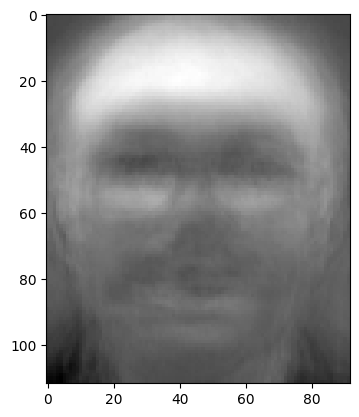

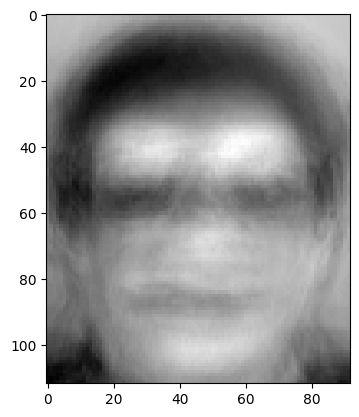

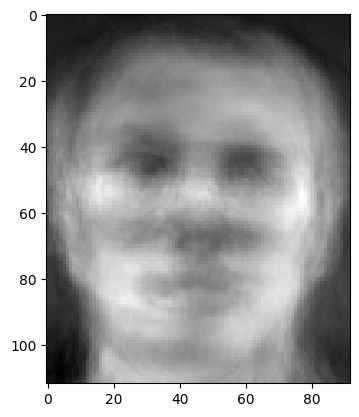

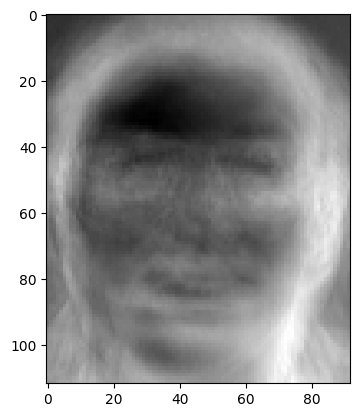

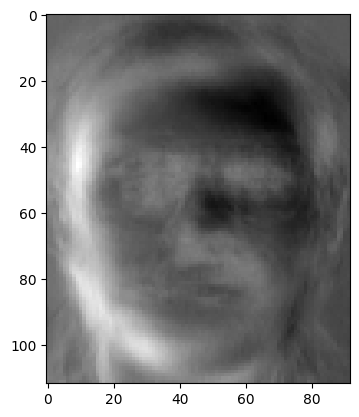

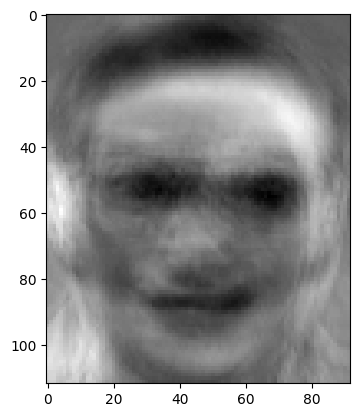

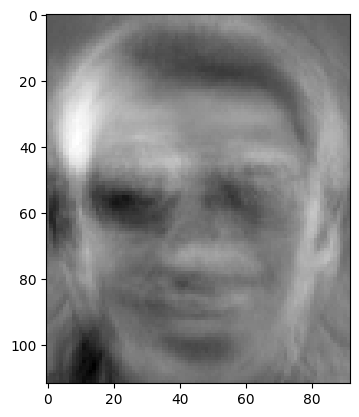

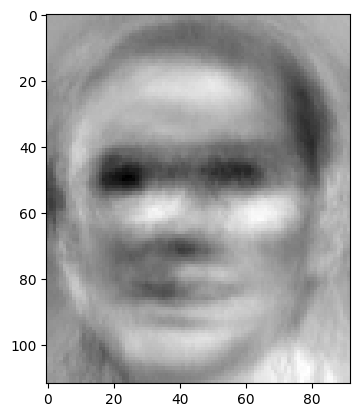

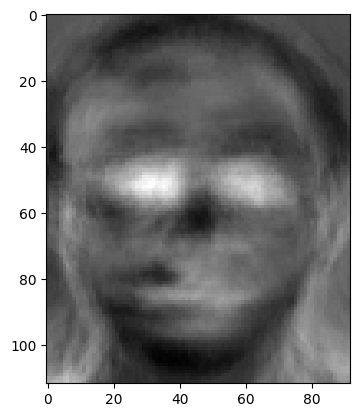

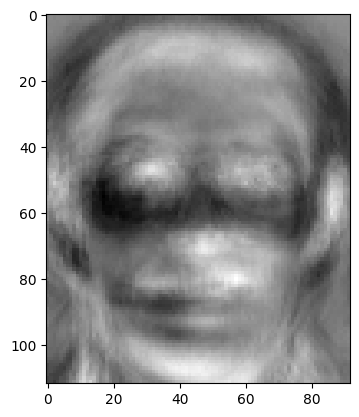

In [4]:
eigenfaces, meanFace = principalComponentAnalysis(trainFaces, 360)
%matplotlib inline
for i in eigenfaces[:10]:
    plt.imshow(i.reshape(112,92), cmap='gray')
    plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [109]:
%matplotlib inline

# Function to implement image reconstruction by taking arguements as necessary.
def imageReconstruction(testFace, eigenfaces, meanFace, q=False):
    reconstructedFace = np.zeros_like(testFace, dtype=np.float64)

    weights = eigenfaces@(testFace-meanFace)
    if np.linalg.norm(weights) != 0:
        weights = 255 * weights/np.linalg.norm(weights)                                 # generate weights for each eigenface from the mean face

    for w, ef in zip(weights, eigenfaces):
        reconstructedFace += ((ef.T@(testFace - meanFace)) * ef)/np.linalg.norm(ef)     # use the weights to reconstruct the face in facespace
    
    reconstructedFace /= len(eigenfaces)                                                # normalise to img coords
    reconstructedFace *= 255

    if not q:
        print("Test: ", testFace[:10], "\nMean: ", meanFace[:10],'\nRec: ', reconstructedFace[:10]/10000)

    return (reconstructedFace + meanFace).reshape(112,92)                               # return the face

Generating covariance matrix...
Generating eigenfaces...
Test:  [121 122 121 123 122 121 123 124 124 123] 
Mean:  [86.49444444 86.28333333 86.69166667 86.69166667 86.77777778 87.05555556
 87.03055556 86.78888889 87.09166667 87.20555556] 
Rec:  [21.21989188 21.87360368 20.84683241 21.65027238 22.01537027 21.8537936
 25.2546956  22.80064374 23.33366744 24.54915393]


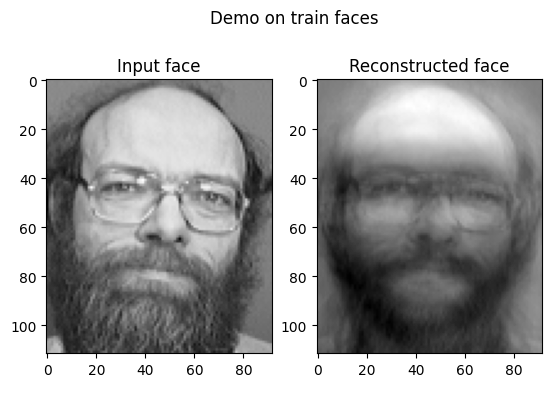

Test:  [39 40 38 41 41 37 41 42 36 42] 
Mean:  [86.49444444 86.28333333 86.69166667 86.69166667 86.77777778 87.05555556
 87.03055556 86.78888889 87.09166667 87.20555556] 
Rec:  [-72.87802043 -73.47165909 -72.36772114 -73.49710589 -73.16488114
 -72.6984475  -72.84379237 -74.19088969 -72.22950802 -72.08822247]


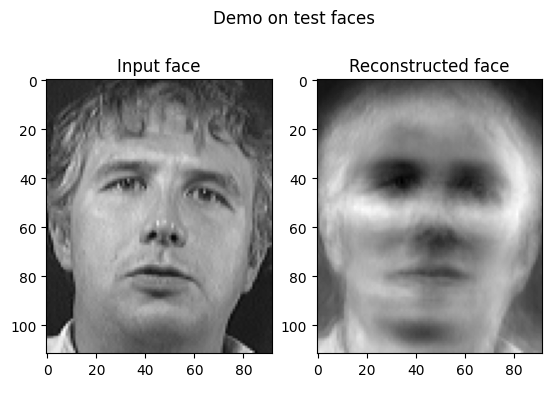

In [147]:
%matplotlib inline

eigenfaces, meanFace = principalComponentAnalysis(trainFaces, 360)

faceNum = 1

trainImg = trainFaces[6]
testImg = testFaces[18]

# train

rTrainImg = imageReconstruction(trainImg.reshape(-1), eigenfaces, meanFace)

fig, ax = plt.subplots()
plt.title("Demo on train faces")
ax.axis('off')

fig.add_subplot(1,2,1)
plt.imshow(trainImg.reshape(112,92), cmap='gray')
plt.title("Input face")

fig.add_subplot(1,2,2)
plt.imshow(rTrainImg, cmap='gray')
plt.title("Reconstructed face")

plt.show()

# test

rTestImg = imageReconstruction(testImg.reshape(-1), eigenfaces, meanFace)

fig, ax = plt.subplots()
plt.title("Demo on test faces")
ax.axis('off')

fig.add_subplot(1,2,1)
plt.imshow(testImg.reshape(112,92), cmap='gray')
plt.title("Input face")

fig.add_subplot(1,2,2)
plt.imshow(rTestImg, cmap='gray')
plt.title("Reconstructed face")

plt.show()



#### Visualisation
Visualise the results for different number of principal components(pc = 5,10,100, 1000, all).

**Note:** Ensure that the images are labelled appropriately.

Generating covariance matrix...
Generating eigenfaces...


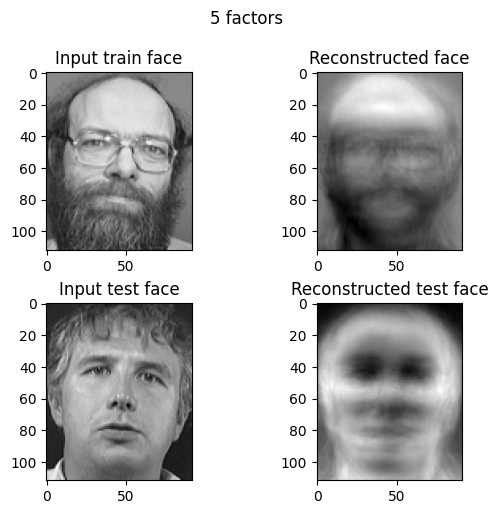

Generating covariance matrix...
Generating eigenfaces...


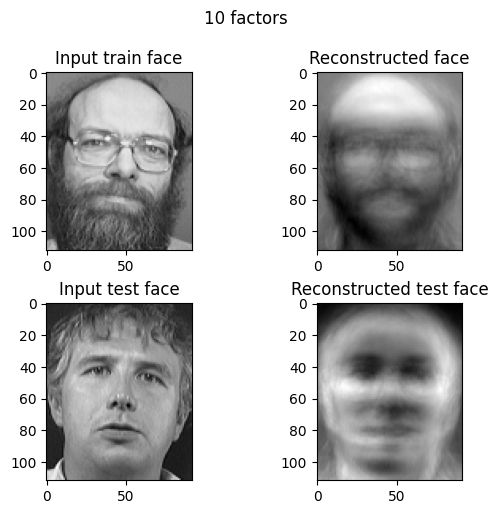

Generating covariance matrix...
Generating eigenfaces...


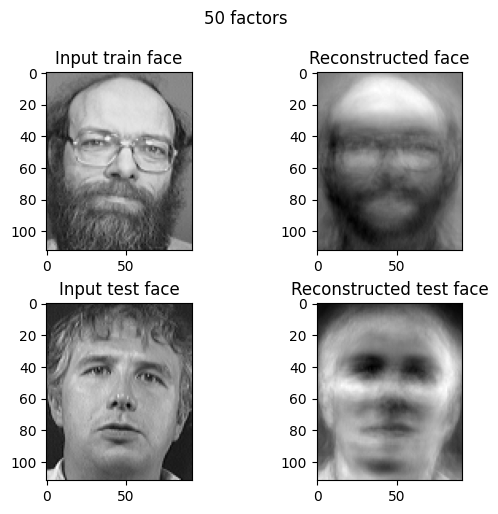

Generating covariance matrix...
Generating eigenfaces...


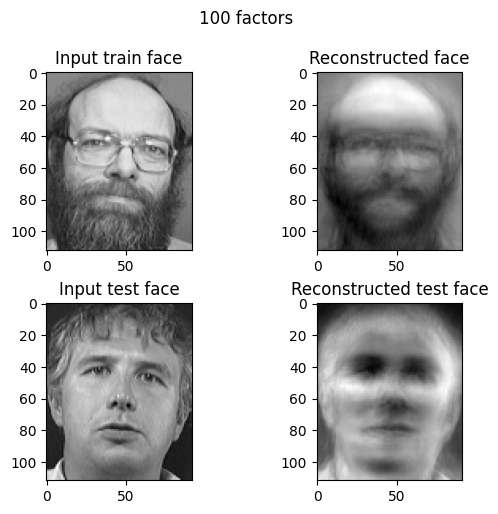

Generating covariance matrix...
Generating eigenfaces...


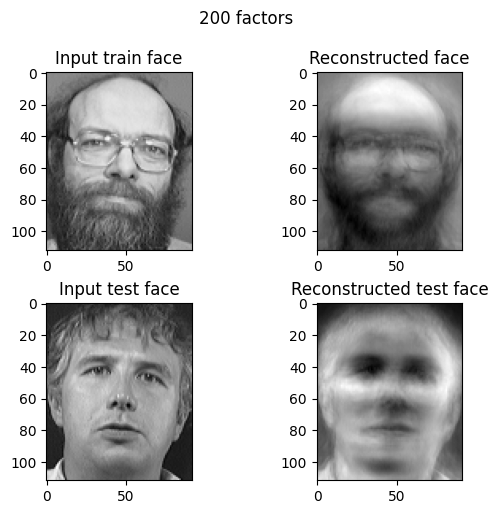

Generating covariance matrix...
Generating eigenfaces...


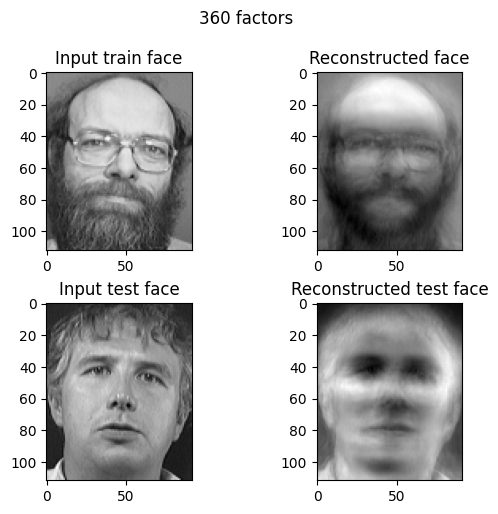

In [149]:
%matplotlib inline

def displayNFacors(n, trainNum=6, testNum=18):
    eigenfaces, meanFace = principalComponentAnalysis(trainFaces, n)

    trainImg = trainFaces[trainNum]
    testImg = testFaces[testNum]

    # train

    rTrainImg = imageReconstruction(trainImg.reshape(-1), eigenfaces, meanFace, q=True)


    plt.subplot(2,2,1)
    plt.imshow(trainImg.reshape(112,92), cmap='gray')
    plt.title("Input train face")

    plt.subplot(2,2,2)
    plt.imshow(rTrainImg, cmap='gray')
    plt.title("Reconstructed face")

    rTestImg = imageReconstruction(testImg.reshape(-1), eigenfaces, meanFace, q=True)

    plt.subplot(2,2,3)
    plt.imshow(testImg.reshape(112,92), cmap='gray')
    plt.title("Input test face")

    plt.subplot(2,2,4)
    plt.imshow(rTestImg, cmap='gray')
    plt.title("Reconstructed test face")

    plt.subplots_adjust(bottom=0, top=0.85, hspace=0.3)
    plt.suptitle("%d factors" % n)
    plt.show()

displayNFacors(5)
displayNFacors(10)
displayNFacors(50)
displayNFacors(100)
displayNFacors(200)
displayNFacors(360)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
"""
Implement pca in the following function by taking the following arguements:
1. Test image
2. Eigenvectors
3. Mean Eigen Face
4. Training Set(X_train,y_train)
The function must return the following:
1. image with smallest error
2. error value
3. prediction class
"""
def model():

  return

In [ ]:
"""
Iterate through all the images in the test data and 
test the accurate by taking different number of components
"""

In [ ]:
# Plot Number of eigenvectors vs Mean Square Error

In [ ]:
# Plot Number of eigenvectors vs Logarithmic Mean Square Error

Summarise your observations on the plots and accuracies

**Answer:**

State the advantages and limitations of using PCA in general. Also state its limitations in context of face recognition

**Answer:**